In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import numpy as np

In [325]:
data = pd.read_csv("train.csv", sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [326]:
data['churn'].value_counts()

churn
no     3652
yes     598
Name: count, dtype: int64

#### Handle duplicates

In [327]:
data.duplicated().any()

False

#### Correlation Analysis

<Axes: >

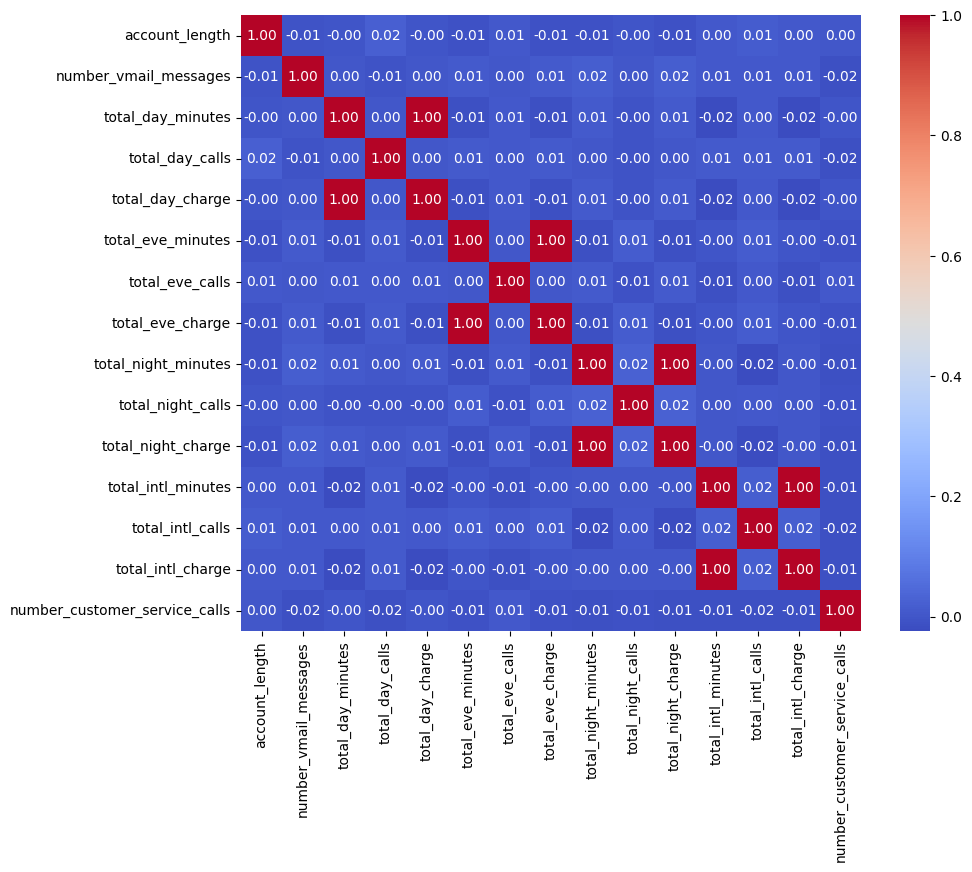

In [328]:
plt.figure(figsize=(10,8))
numeric_data = data.select_dtypes(exclude='object')
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [329]:
data = data.drop(['voice_mail_plan','total_day_charge','total_eve_charge','total_night_charge','total_night_charge','total_intl_charge'],axis=1)
data.head()

,state,account_length,area_code,international_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,OH,107,area_code_415,no,26,161.6,123,195.5,103,254.4,103,13.7,3,1,no
1,NJ,137,area_code_415,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,no
2,OH,84,area_code_408,yes,0,299.4,71,61.9,88,196.9,89,6.6,7,2,no
3,OK,75,area_code_415,yes,0,166.7,113,148.3,122,186.9,121,10.1,3,3,no
4,MA,121,area_code_510,no,24,218.2,88,348.5,108,212.6,118,7.5,7,3,no


In [330]:
numeric_data = data.select_dtypes(exclude='object')
numeric_data.describe().T

,count,mean,std,min,25%,50%,75%,max
account_length,4250.0,100.236235,39.698401,1.0,73.000,100.00,127.000,243.0
number_vmail_messages,4250.0,7.631765,13.439882,0.0,0.000,0.00,16.000,52.0
total_day_minutes,4250.0,180.259600,54.012373,0.0,143.325,180.45,216.200,351.5
total_day_calls,4250.0,99.907294,19.850817,0.0,87.000,100.00,113.000,165.0
total_eve_minutes,4250.0,200.173906,50.249518,0.0,165.925,200.70,233.775,359.3
total_eve_calls,4250.0,100.176471,19.908591,0.0,87.000,100.00,114.000,170.0
total_night_minutes,4250.0,200.527882,50.353548,0.0,167.225,200.45,234.700,395.0
total_night_calls,4250.0,99.839529,20.093220,0.0,86.000,100.00,113.000,175.0
total_intl_minutes,4250.0,10.256071,2.760102,0.0,8.500,10.30,12.000,20.0
total_intl_calls,4250.0,4.426353,2.463069,0.0,3.000,4.00,6.000,20.0


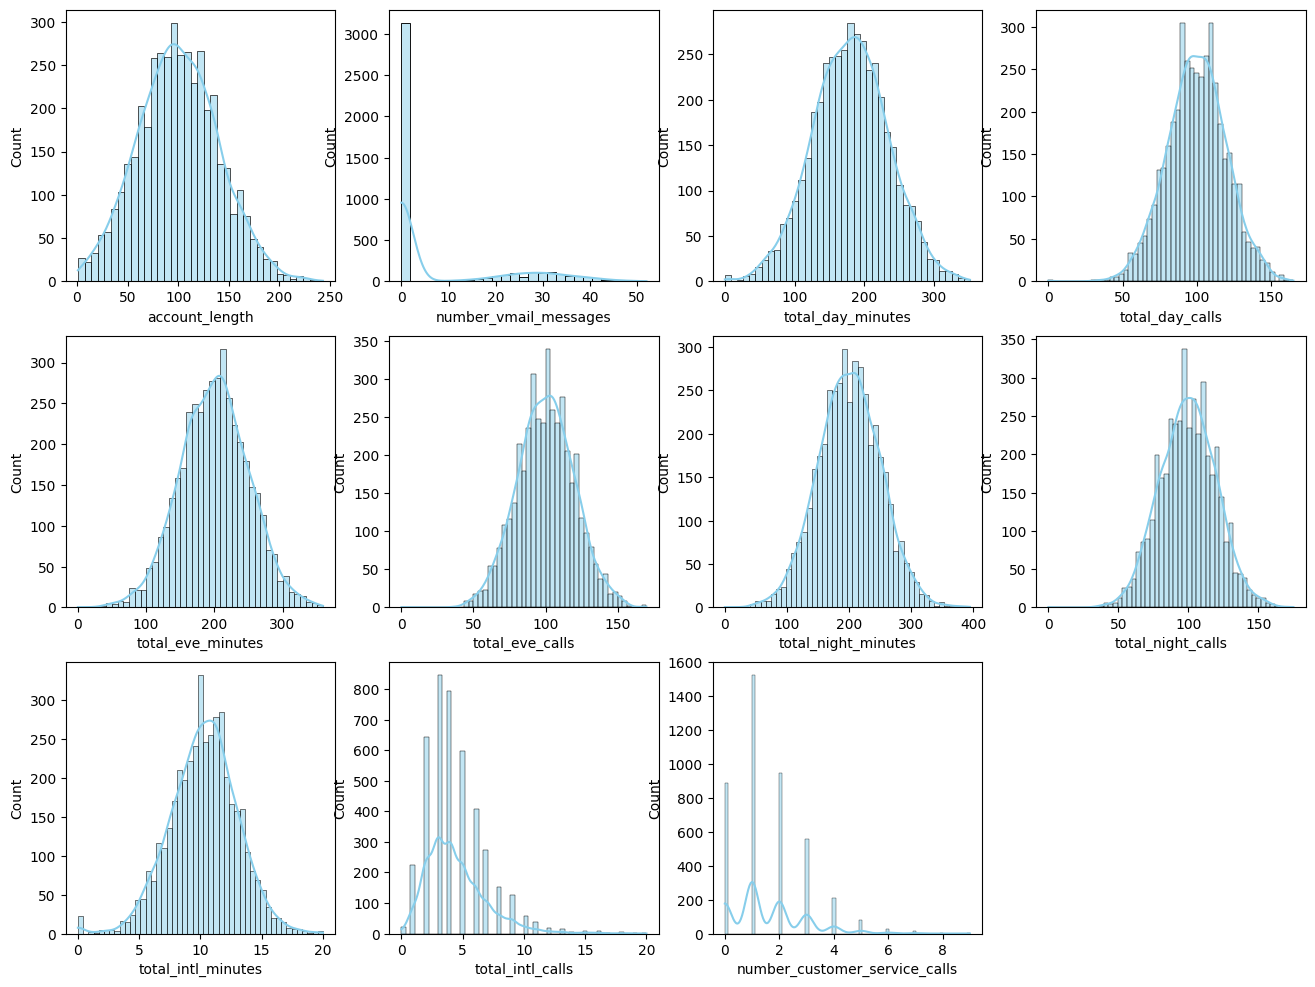

In [331]:
num_rows = (len(numeric_data.columns) - 1) // 4 + 1
plt.figure(figsize=(16, 4 * num_rows))
for i, column in enumerate(numeric_data.columns):
    plt.subplot(num_rows, 4, i + 1)
    sns.histplot(data=numeric_data[column], kde=True, color='skyblue', edgecolor='black')

#### Transform the categorial data into numerical data

In [332]:
data['churn'] = data['churn'].replace({'yes':1, 'no':0})
data['international_plan'] = data['international_plan'].replace({'yes':1, 'no':0})


In [333]:
data.groupby(['state', 'churn']).size().unstack().fillna(0).T

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,57,88,60,70,29,71,73,64,67,67,57,73,55,94,73,70,72,73,62,75,67,73,72,89,70,67,63,73,61,68,68,70,68,66,80,83,62,84,59,81,58,64,67,79,85,95,76,62,87,120,85
1,4,13,11,7,10,9,15,8,13,9,7,4,7,12,6,13,15,12,7,14,19,16,15,19,10,15,17,7,6,5,10,26,10,17,16,12,16,15,8,6,14,11,12,19,12,5,10,18,7,19,10


In [334]:
data = data.drop(['state','area_code'], axis=1)
data.head()

,account_length,international_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,107,0,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
1,137,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
2,84,1,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
3,75,1,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0
4,121,0,24,218.2,88,348.5,108,212.6,118,7.5,7,3,0


#### Select features using Random Forest

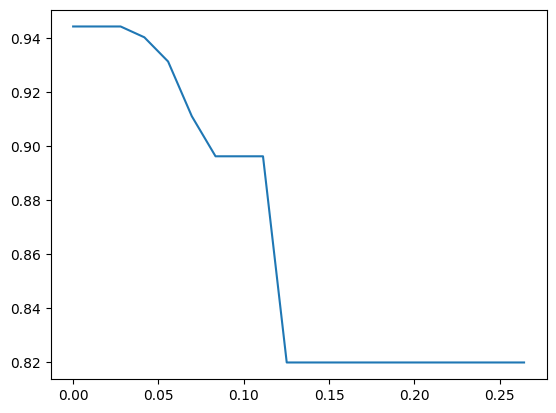

In [335]:
Xtrain = data.drop('churn',axis=1)
Ytrain = data.churn
RFC_clf = RFC(n_estimators=10,random_state=0)
X_embedded = SelectFromModel(RFC_clf,threshold=0.05).fit_transform(Xtrain,Ytrain)
importance = RFC_clf.fit(Xtrain,Ytrain).feature_importances_
threshold = np.linspace(0,importance.max(),20)
score = []
for i in threshold:
    X_embedded = SelectFromModel(RFC_clf,threshold=i).fit_transform(Xtrain,Ytrain)
    val = cross_val_score(RFC_clf,X_embedded,Ytrain,cv=5).mean()
    score.append(val)
plt.plot(threshold,score)
plt.show()

In [336]:
a=threshold[np.argmax(score)] 
X_embedded = SelectFromModel(RFC_clf,threshold=a).fit_transform(Xtrain,Ytrain)
col_k = list(Xtrain.columns[RFC_clf.feature_importances_>a])
col_k

['account_length',
 'international_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_eve_minutes',
 'total_eve_calls',
 'total_night_minutes',
 'total_night_calls',
 'total_intl_minutes',
 'total_intl_calls',
 'number_customer_service_calls']

In [337]:
data.columns[data.columns != 'churn'].to_list() == col_k

True

#### Save the training dataset

In [338]:
data.to_csv('Train1.0.csv')

#### Handle Test dataset

In [3]:
test_data = pd.read_csv("test.csv", sep=',')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

In [4]:
test_data.duplicated().any()

False

In [5]:
test_data = test_data.drop(['area_code', 'state','voice_mail_plan'],axis=1)
test_data['international_plan'] = test_data['international_plan'].replace({'yes':1, 'no':0})
test_data = test_data.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'],axis=1)

In [6]:
test_data.to_csv("Test1.0.csv")